<a href="https://colab.research.google.com/github/MeazaEyakem1/Application-of-AI-in-Medical-Imaging-/blob/main/UNET_Super_Resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

from torchvision.datasets.utils import download_file_from_google_drive
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from torch import Tensor

import os

from skimage import data
from skimage.color import rgb2gray

from torchvision.datasets.folder import default_loader

In [2]:
import torch
torch.cuda.empty_cache()


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
def make_dataset_train(root: str) -> list:
    """Reads a directory with data.
    """
    dataset = []

    lr_dir = 'Data/Train_LR'
    hr_dir = 'Data/Train_SR'
    
    # Get all the filenames from lr
    lr_fnames = sorted(os.listdir(os.path.join(root, lr_dir)))
 

    hr_fnames = sorted(os.listdir(os.path.join(root, hr_dir)))
 
    i = 1

    # Compare file names
    for hr_fname in hr_fnames:

    

      #if i < 6 : 

      if hr_fname in lr_fnames:

        # create pair of full path to the corresponding images
        lr_path = os.path.join(root, lr_dir, hr_fname)
        hr_path = os.path.join(root, hr_dir, hr_fname)

        item = (lr_path, hr_path)
                  # append to the list dataset
        dataset.append(item)
        i = i + 1
              
      #else:
       # continue
      

    return dataset

In [6]:
def make_dataset_test(root: str) -> list:
    """Reads a directory with data.
    """
    dataset = []
    i = 1

    # dir names 
    lr_dir = 'Data/Test_LR'
    hr_dir = 'Data/Test_SR'
    
    # Get all the filenames from lr
    lr_fnames = sorted(os.listdir(os.path.join(root, lr_dir)))

    hr_fnames = sorted(os.listdir(os.path.join(root, hr_dir)))
    i= i+1

    # Compare file names:
    for hr_fname in sorted(os.listdir(os.path.join(root, hr_dir))):
     

      #if i < 6:

      if hr_fname in lr_fnames:
        # create pair of full path to the corresponding images
        lr_path = os.path.join(root, lr_dir, hr_fname)
        hr_path = os.path.join(root, hr_dir, hr_fname)

        item = (lr_path, hr_path)
        # append to the list dataset
        dataset.append(item)
        i = i + 1
      #else : 
       #  continue
                 
              

    return dataset

In [7]:
from torch.utils.data import Dataset
from torchvision.datasets.folder import default_loader
from torchvision.datasets.folder import pil_loader

class CustomDatasetTrain(Dataset):
  def __init__(self,
               root = 'gdrive/My Drive',
               loader=pil_loader,
               transform=None,
               transform2=None):


      self.root = root
      self.target_transform = transform
      self.target_transform2 = transform2

      # Prepare dataset
      samples = make_dataset_train(self.root)
      
      self.loader = loader
      self.samples = samples
      # list of lr
      self.lr_samples = [s[1] for s in samples]
      # list of hr
      self.hr_samples = [s[1] for s in samples]

  def __getitem__(self, index):
      """Returns a data sample from  dataset.
      """
      # getting our paths to images
      lr_path, hr_path = self.samples[index]
        
      # import each image using loader
      lr_sample = self.loader(lr_path)
      hr_sample = self.loader(hr_path)
        
      # tranforms

      lr_sample = self.target_transform(lr_sample)
      hr_sample = self.target_transform(hr_sample)      


      return lr_sample, hr_sample

  def __len__(self):
      return len(self.samples)

In [8]:
from torch.utils.data import Dataset
from torchvision.datasets.folder import default_loader

class CustomDatasetTest(Dataset):
  def __init__(self,
               root = 'gdrive/My Drive',
               loader=pil_loader,
               transform=None,
               transform2=None):


      self.root = root
      self.target_transform = transform
      self.target_transform2 = transform2

      # Prepare dataset
      samples = make_dataset_test(self.root)

      self.loader = loader
      self.samples = samples
      # list of lr
      self.lr_samples = [s[1] for s in samples]
      # list of hr
      self.hr_samples = [s[1] for s in samples]


  def __getitem__(self, index):
      """Returns a data sample from  dataset.
      """
      # getting paths to images
      lr_path, hr_path = self.samples[index]
        
      # import each image using loader
      lr_sample = self.loader(lr_path)
      hr_sample = self.loader(hr_path)
        
      # tranforms
      lr_sample = self.target_transform(lr_sample)
      hr_sample = self.target_transform(hr_sample)      

      return lr_sample, hr_sample

  def __len__(self):
      return len(self.samples)

In [9]:
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF

im_tf = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((96,128)),                  
    transforms.ToTensor(),
    transforms.Normalize((0), (1))
])

sm_tf = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((192,256)),                  
    transforms.ToTensor(),
    transforms.Normalize((0), (1))
])

# create training and validation datasets

#My own dataset

train_set = CustomDatasetTrain(transform=sm_tf)

valid_set = CustomDatasetTest(transform=sm_tf)
print(len(train_set))
print(len(valid_set))

1000
300


In [10]:
# create a data loader
train_loader = DataLoader(train_set, batch_size=5, shuffle=True)

# create a validation loader 
valid_loader = DataLoader(valid_set, batch_size=5, shuffle = False)

print(f'train samples: {len(train_loader)}')
print(f'test samples: {len(valid_loader)}')

train samples: 200
test samples: 60


In [11]:
class AverageBase(object):
    
    def __init__(self, value=0):
        self.value = float(value) if value is not None else None
       
    def __str__(self):
        return str(round(self.value, 4))
    
    def __repr__(self):
        return self.value
    
    def __format__(self, fmt):
        return self.value.__format__(fmt)
    
    def __float__(self):
        return self.value
    

class RunningAverage(AverageBase):
    """
    Keeps track of a cumulative moving average (CMA).
    """
    
    def __init__(self, value=0, count=0):
        super(RunningAverage, self).__init__(value)
        self.count = count
        
    def update(self, value):
        self.value = (self.value * self.count + float(value))
        self.count += 1
        self.value /= self.count
        return self.value


class MovingAverage(AverageBase):
    """
    An exponentially decaying moving average (EMA).
    """
    
    def __init__(self, alpha=0.99):
        super(MovingAverage, self).__init__(None)
        self.alpha = alpha
        
    def update(self, value):
        if self.value is None:
            self.value = float(value)
        else:
            self.value = self.alpha * self.value + (1 - self.alpha) * float(value)
        return self.value

In [12]:

class SalUNet(nn.Module):
    def __init__(self):
        super(SalUNet, self).__init__()

       
        # new resolution 256*192

        self.conv0_e1 = ConvAct(1, 32)
        self.conv0_e2 = ConvAct(32, 32)
        self.down0 = nn.MaxPool2d(2, 2)

        #new resoulution 128 * 96
        self.conv1_e1 = ConvAct(32, 64)
        self.conv1_e2 = ConvAct(64, 64)
        self.down1 = nn.MaxPool2d(2, 2)

       
        #new resoulution 64 * 48
        self.conv2_e1 = ConvAct(64, 128)
        self.conv2_e2 = ConvAct(128, 128)
        self.down2 = nn.MaxPool2d(2, 2)
        
      
        # new resolution: 32 x 16
        self.conv3_e1 = ConvAct(128, 256)
        self.conv3_e2 = ConvAct(256, 256)
        self.down3 = nn.MaxPool2d(2, 2)
        
      
        # new resolution: 16 x 12
        self.conv4_e1 = ConvAct(256, 512)
        self.conv4_e2 = ConvAct(512, 512)
        self.down4 = nn.MaxPool2d(2, 2)

        # new resolution: 8 x 6
        self.conv5_1 = ConvAct(512, 1024)
        self.conv5_2 = ConvAct(1024, 1024) 
    
        #decoding part 
        # resolution: 16 x 12
        self.up4 = nn.ConvTranspose2d(1024, 512, 3, 2, 1, 1)
        self.conv4_d1 = ConvAct(1024, 512)
        self.conv4_d2 = ConvAct(512, 512)

        # resolution: 32 x 24
        self.up3 = nn.ConvTranspose2d(512, 256, 3, 2, 1, 1)
        self.conv3_d1 = ConvAct(512, 256)
        self.conv3_d2 = ConvAct(256, 256)

        # resolution: 64 * 48
        self.up2 = nn.ConvTranspose2d(256, 128, 3, 2, 1, 1)
        self.conv2_d1 = ConvAct(256, 128)
        self.conv2_d2 = ConvAct(128, 128)

        # resolution: 128 x 96
        self.up1 = nn.ConvTranspose2d(128, 64, 3, 2, 1, 1)
        self.conv1_d1 = ConvAct(128, 64)
        self.conv1_d2 = ConvAct(64, 64)

        #256*192
        self.up0 = nn.ConvTranspose2d(64, 32, 3, 2, 1, 1)
        self.conv0_d1 = ConvAct(64, 32)
        self.conv0_d2 = ConvAct(32, 32)

        self.output_layer = ConvAct(32,1,1,1, activation = "leakyrelu")
   

    def forward(self, x):

        # level 1 - encode
        x = self.conv0_e1(x)
        x = out0 = self.conv0_e2(x)
        x = self.down0(x)
        
        # level 1 - encode
        x = self.conv1_e1(x)
        x = out1 = self.conv1_e2(x)
        x = self.down1(x)

        # level 2 - encode
        x = self.conv2_e1(x)
        x = out2 = self.conv2_e2(x)
        x = self.down2(x)

        # level 3 - encode
        x = self.conv3_e1(x)
        x = out3 = self.conv3_e2(x)
        x = self.down3(x)

        # level 4 - encode
        x = self.conv4_e1(x)
        x = out4 = self.conv4_e2(x)
        x = self.down4(x)

        # level 5 - encode/decode
        x = self.conv5_1(x)
        x = self.conv5_2(x)

        # level 4 - decode
        x = self.up4(x)
        x = torch.cat((x, out4), dim=1)
        x = self.conv4_d1(x)
        x = self.conv4_d2(x)

        # level 3 - decode
        x = self.up3(x)
        x = torch.cat((x, out3), dim=1)
        x = self.conv3_d1(x)
        x = self.conv3_d2(x)

        # level 2 - decode
        x = self.up2(x)
        x = torch.cat((x, out2), dim=1)
        x = self.conv2_d1(x)
        x = self.conv2_d2(x)

        # level 1 - decode
        x = self.up1(x)
        x = torch.cat((x,out1),dim=1)
        x = self.conv1_d1(x)
        x = self.conv1_d2(x)

        # level 0 - decode
        x = self.up0(x)
        x = torch.cat((x,out0),dim=1)
        x = self.conv0_d1(x)
        x = self.conv0_d2(x)

        # make predictions
        x = self.output_layer(x)
        #x = lin(x)
        #x = x.view(x.size(0), 1, 256, 192)
        #print(shape(x))
        return x

    

_named_activations = {
    'relu': nn.ReLU,
    'sigmoid': nn.Sigmoid,
    'prelu': nn.PReLU,
    'leakyrelu': nn.LeakyReLU,
    'elu': nn.ELU,
    'Tanh':nn.Tanh
}

def same_padding(kernel, dilation):
    return int((kernel + (kernel - 1) * (dilation - 1) - 1) / 2)


def get_activation_by_name(name, **kwargs):
    return _named_activations[name](**kwargs)


class ConvAct(nn.Module):
    """Conv->Activation"""
    def __init__(
            self, in_channels, out_channels,
            kernel=3, dilation=1, activation='relu'):
        super(ConvAct, self).__init__()
        padding = same_padding(kernel, dilation)
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel,
            padding=padding,
            dilation=dilation)
        self.activation = get_activation_by_name(activation)
        self.reset_parameters()

    def reset_parameters(self):
        self.conv.reset_parameters()
        nn.init.xavier_uniform_(self.conv.weight)

    def forward(self, x):
        return self.activation(self.conv(x))

In [13]:
# instantiate model and move it to the GPU
device = 'cuda'
model = SalUNet()
model.to(device);

In [14]:
# save checkpoints to the checkpoints folder. Create it.
!mkdir -p checkpoints

In [15]:
def save_checkpoint(optimizer, model, epoch, filename):
    checkpoint_dict = {
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [16]:
# create the criterion to optimize (the loss function).
criterion = nn.L1Loss()

# create an SGD optimizer with learning rate 0.01, momentum 0.9, and nesterov momentum turned on
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)


In [17]:
def train_for_epoch(loader, model, optimizer, criterion):
    n_steps = len(train_loader)    
    
    # put the model in train mode
    model.train()

    # iterate over batches
    for step, (batch, targets) in enumerate(loader):

        # Move the training data to the GPU
        batch = batch.to(device)
        targets = targets.to(device)

        # clear previous gradient computation
        optimizer.zero_grad()

        # forward propagation
        predictions = model(batch)

        # calculate the loss
        loss = criterion(predictions, targets)

        # backpropagate to compute gradients
        loss.backward()
        psnr = 1
      
        
        # update model weights
        optimizer.step()
        
        yield step, n_steps, float(loss) , float(psnr)
        

def validate(loader, model, optimizer, criterion):

    n_steps = len(loader)  
    
    # put the model in eval mode
    model.eval()
    
    # use a running average to keep track of the average loss
    valid_loss = RunningAverage(count=len(loader))
    avg_psnr = RunningAverage()
    mov_psnr = MovingAverage()
    
    # no_grad to save memory
    with torch.no_grad():

        for step, (batch, targets) in enumerate(loader):
            # Move the training batch to the GPU
            batch = batch.to(device)
            targets = targets.to(device)

            # forward propagation
            predictions = model(batch)

            # calculate the loss
            loss = criterion(predictions, targets)

            mse_loss = nn.MSELoss()
            mse = mse_loss(predictions,targets)

            psnr = 10 * torch.log10(np.square(1.0)/(mse))
            avg_psnr.update(psnr)
            mov_psnr.update(psnr)

            # update running loss value
            valid_loss.update(loss)
            
            print(f'\rBatch {step+1:03d}/{n_steps}  valid_loss: {valid_loss.value:0.4f}', end='', flush=True)
            
    
    return valid_loss.value,psnr,avg_psnr.value,mov_psnr.value
        

def monitor_progress(train_generator):
    start_time = time.time()
    for step, n_steps, loss, psnr in train_generator:
        elapsed = int(time.time() - start_time)

        print(f'\rBatch {step+1:03d}/{n_steps}  loss: {loss:0.4f}  elapsed: {elapsed}s',
              end='', flush=True)
    yield step, n_steps, loss, psnr
        
def track_running_average_loss(train_generator):
    average_loss = MovingAverage()
    average_psnr = MovingAverage()

    for step, n_steps, loss, psnr in train_generator:
        average_loss.update(loss)
        #psnr = PSNR(average_loss.value)

        average_psnr.update(psnr)
        yield step, n_steps, average_loss.value, average_psnr.value
        
        
def run_train_generator(train_generator):
    for step, n_steps, loss , psnr in train_generator:
        pass
    return loss,psnr
           

In [18]:
def train(first_epoch, n_epochs):

    # keep track of losses
    train_losses, valid_losses = [], []

    psnrs , n_psnrs = [], []
    down_psnrs,mov_psnrs = [],[]
    for epoch in range(first_epoch, n_epochs + first_epoch):

        # train
        train_generator = train_for_epoch(train_loader, model, optimizer, criterion)
        train_generator = track_running_average_loss(train_generator)
        train_generator = monitor_progress(train_generator)
        train_loss, psnr = run_train_generator(train_generator)
        
        train_losses.append(train_loss)

        # validate n_psnr/non updated(averaged) psnr
        valid_loss , psnr , down_psnr, mov_psnr= validate(valid_loader, model, optimizer, criterion)
        
        valid_losses.append(valid_loss)
        psnrs.append(psnr)
        down_psnrs.append(down_psnr)
        mov_psnrs.append(mov_psnr)
        
        print('\nEpoch {:.5f}, train_loss {:.5f} Validation_loss: {:.5f}'.format(epoch,train_loss, valid_loss))
        #print('\nEpoch {} validation loss: {:.5f}'.format(epoch, valid_loss))

        # Save a checkpoint
        checkpoint_filename = 'checkpoints/salunet-{:03d}.pkl'.format(epoch)
        save_checkpoint(optimizer, model, epoch, checkpoint_filename)
   
    return train_losses, valid_losses, psnrs, down_psnrs, mov_psnrs

In [19]:
train_losses, valid_losses,psnrs , avg_psnrs, mov_psnrs = train(first_epoch=1, n_epochs=5)

Batch 001/200  loss: 0.3690  elapsed: 3s

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Batch 060/60  valid_loss: 0.0221
Epoch 1.00000, train_loss 0.12317 Validation_loss: 0.02213
Batch 060/60  valid_loss: 0.0141
Epoch 2.00000, train_loss 0.03488 Validation_loss: 0.01407
Batch 060/60  valid_loss: 0.0139
Epoch 3.00000, train_loss 0.02789 Validation_loss: 0.01394
Batch 060/60  valid_loss: 0.0115
Epoch 4.00000, train_loss 0.02470 Validation_loss: 0.01150
Batch 060/60  valid_loss: 0.0109
Epoch 5.00000, train_loss 0.02293 Validation_loss: 0.01093


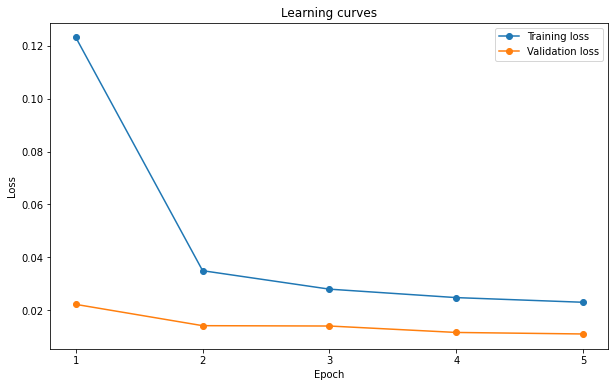

In [20]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, train_losses, '-o', label='Training loss')
plt.plot(epochs, valid_losses, '-o', label='Validation loss')
plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.show()

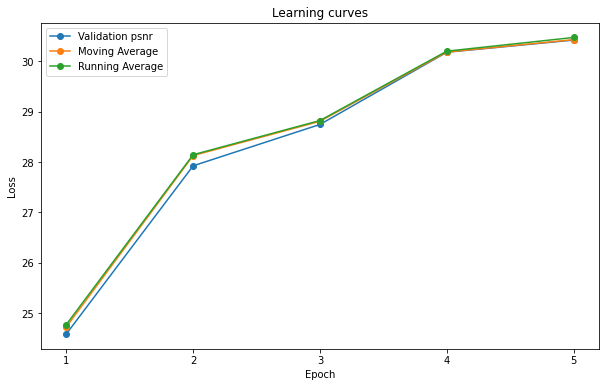

[tensor(24.5844, device='cuda:0'), tensor(27.9264, device='cuda:0'), tensor(28.7475, device='cuda:0'), tensor(30.1826, device='cuda:0'), tensor(30.4249, device='cuda:0')]
[24.724736722310386, 28.12997277577718, 28.81120309829712, 30.186205863952637, 30.433141167958578]
[24.77257935358737, 28.146310997751446, 28.825996529851, 30.204377970029842, 30.47651409297507]


In [21]:
epochs = range(1, len(valid_losses) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, psnrs, '-o', label='Validation psnr')
plt.plot(epochs, avg_psnrs, '-o', label='Moving Average')
plt.plot(epochs, mov_psnrs, '-o', label='Running Average')
plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.show()
print(psnrs)
print(avg_psnrs)
print(mov_psnrs)

In [22]:
def show_examples(dataset, model, count=5, size=(3.3, 2.5)):
    loader = DataLoader(dataset, batch_size=5, shuffle=False)
    
    # put model in eval mode
    model.eval()
    
    # create a colab grid
    grid = widgets.Grid(3, count)
    
    pix_mean = torch.as_tensor([0, 0, 0], dtype=torch.float32, device=device)
    pix_std = torch.as_tensor([1, 1, 1], dtype=torch.float32, device=device)
    

    with torch.no_grad():
        for i, (batch, targets) in enumerate(itertools.islice(loader, count)):
            batch = batch.to(device)
            targets = targets.to(device)
            predictions = model(batch)
            
            # unnormalize image
            image = batch[1].mul(pix_std[:, None, None]).add(pix_mean[:, None, None])
            image.clamp_(0,1)

            targets = targets[1].mul(pix_std[:, None, None]).add(pix_mean[:, None, None])
            targets.clamp_(0,1)

            predictions = predictions[1].mul(pix_std[:, None, None]).add(pix_mean[:, None, None])
            predictions.clamp_(0,1)

            # convert to PIL images
            image = tF.to_pil_image(image.cpu())
            target = tF.to_pil_image(targets.cpu())
            y_pred = tF.to_pil_image(predictions.cpu())
            
            # display
            with grid.output_to(0,i):
                grid.clear_cell()
                plt.figure(figsize=size)
                plt.imshow(image)
                plt.savefig("image" + str(i))
            with grid.output_to(1,i):
                grid.clear_cell()
                plt.figure(figsize=size)
                plt.imshow(target)
                plt.savefig("target" + str(i))
            with grid.output_to(2,i):
                grid.clear_cell()
                plt.figure(figsize=size)
                plt.imshow(y_pred)
                plt.savefig("result" + str(i))

,,,,
,,,,
,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

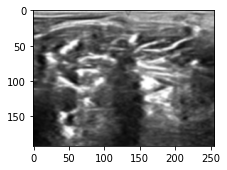

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

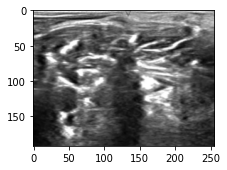

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

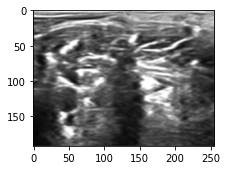

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

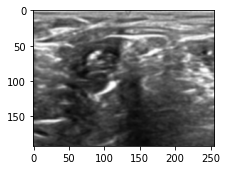

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

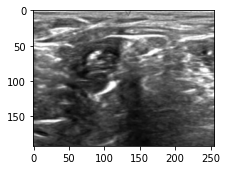

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

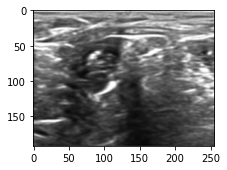

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

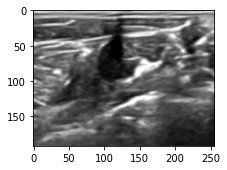

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

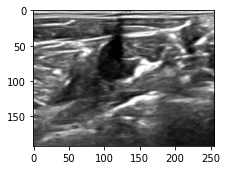

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

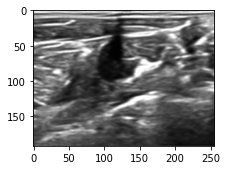

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

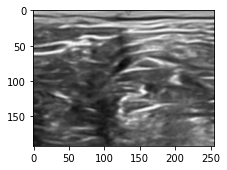

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

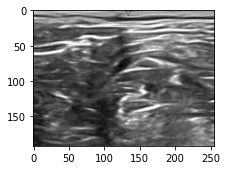

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

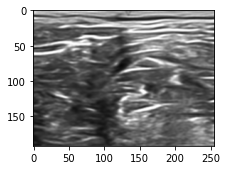

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

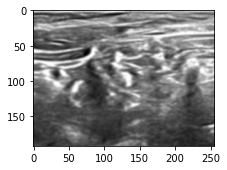

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

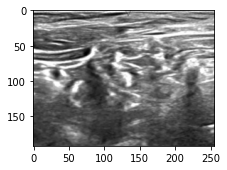

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

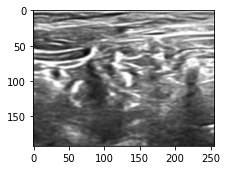

<IPython.core.display.Javascript object>

In [23]:
from google.colab import widgets
import itertools

show_examples(valid_set, model)

# New Section